# Bottleneck likelihood for global epistasis models
This Python Jupyter notebook deals with a rather subtle point: how to calculate the log likelihoods for the [global epistasis models](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html).
Specifically, it explains and illustrates the "bottleneck likelihood" calculation method, which is a way of calculating the likelihoods of variant phenotypes given sequencing counts from deep mutational scanning experiments that are subject to substantial bottlenecks when going from the pre- to post-selection conditions.

## Motivation
The bottleneck likelihood is appropriate when most noise in the experiment comes from a bottleneck when passaging the library from the pre-selection to post-selection condition.
This will be the case when the total pre- and post-selection sequencing depths greatly exceed the number of variants that were physically passaged from the pre-selection library to the post-selection one.
At least in Bloom lab deep mutational scanning experiments, this condition is quite common.

When experimental bottlenecks are smaller than the sequencing depths, noise in the statistical estimation of the pre- and post-selection variant frequencies (which forms the basis for the Gaussian likelihood calculations of [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550)) is overwhelmed by the experimental noise associated with the bottlenecking.
Therefore, we can get much better and more accurate calculations by focusing the likelihood calculation on handling the bottlenecks.

Note that this form of the likelihood also assumes that an appreciable fraction of the variants are wildtype, such that there is not substantial bottleneck-induced noise in the fraction of the library that is wildtype.

## Mathematical definition
Let $n_v^{\text{pre}}$ and $n_v^{\text{post}}$ be the pre-selection and post-selection counts for variant $v$.
The estimated frequencies of the variant pre- and post-selection are

$$f_v^{\text{pre}} = \frac{n_v^{\text{pre}} + C}{\sum_{v'} \left(n_{v'}^{\text{pre}} + C\right)}$$

and

$$f_v^{\text{post}} = \frac{n_v^{\text{post}} + C}{\sum_{v'} \left(n_{v'}^{\text{post}} + C\right)}$$
        
where $C$ is a pseudocount which by default is 0.5.
Because the sequencing depth greatly exceeds the experiment bottleneck, we disregard statistical error in the estimation of $f_v^{\text{pre}}$ and $f_v^{\text{post}}$ and instead take these as exact measurements.

Let $N_{\text{bottle}}$ be the bottleneck when passaging the pre-selection library to the post-selection condition.
As mentioned above, we assume this bottleneck is much smaller than the sequencing depth (meaning that $N_{\text{bottle}} \ll \sum_{v} n_{v}^{\text{pre}}, \sum_{v} n_{v}^{\text{pre}}$).
Let $n_v^{\text{bottle}}$ be the number of variants $v$ that survive the bottleneck, with $N_{\text{bottle}} = \sum_v n_v^{\text{bottle}}$.
Note that $n_v^{\text{bottle}}$ is **not** an experimental observable, although it may be possible to experimentally estimate $N_{\text{bottle}}$.

Furthermore, let $F_{\text{wt}}^{\text{pre}} = \sum_{v = \text{wt}} f_v^{\text{pre}}$ be the total fraction of the library that is composed of wildtype variants pre-selection, and let $F_{\text{wt}}^{\text{post}} = \sum_{v = \text{wt}} f_v^{\text{post}}$ be the fraction post-selection.
We assume that $F_{\text{wt}}^{\text{post}}$ is sufficiently large that it is not much affected by the bottleneck (in other words, we assume that $\frac{\sum_{v = \text{wt}} n_v^{\text{bottle}}}{N_{\text{bottle}}} \approx F_{\text{wt}}^{\text{post}}$).

After the bottleneck, selection will change the frequency of variant $v$ relative to wildtype by an amount proportional to $2^{p\left(v\right)}$ where $p\left(v\right)$ is the observed phenotype of the variant.
So

$$\frac{f_v^{\text{post}}}{F_{\text{wt}}^{\text{post}}} = 2^{p\left(v\right)} \frac{n_v^{\text{bottle}}}{F_{\text{wt}}^{\text{pre}} \times N_{\text{bottle}}}.$$

We can rearrange this equation to yield:

$$n_v^{\text{bottle}} = \frac{f_v^{\text{post}} \times F_{\text{wt}}^{\text{pre}} \times N_{\text{bottle}}} {F_{\text{wt}}^{\text{post}} \times 2^{p\left(v\right)}}.$$

The above equation tells us what the value of $n_v^{\text{bottle}}$ must have been given the pre- and post-selection counts, the overall bottleneck during the passaging of the library, and the observed phenotype $p\left(v\right)$ of variant $v$.

We can also know that the probability distribution over $n_v^{\text{bottle}}$ should be Poisson distributed with mean $N_{\text{bottle}} \times f_v^{\text{pre}}$.
We can therefore calculate the log likelihood of the data that imply a specific value for $n_v^{\text{bottle}}$ as:

$$
\begin{eqnarray}
\mathcal{L}_v
&=&
\ln \left[\exp\left(-N_{\text{bottle}} f_v^{\text{pre}}\right) \frac{\left(N_{\text{bottle}} f_v^{\text{pre}}\right)^{n_v^{\text{bottle}}}}{\Gamma\left(n_v^{\text{bottle}} + 1\right)}\right] \\
&=&
n_v^{\text{bottle}} \ln \left(N_{\text{bottle}} f_v^{\text{pre}}\right) - 
\ln \Gamma\left(n_v^{\text{bottle}} + 1\right) -
N_{\text{bottle}} f_v^{\text{pre}}
\end{eqnarray}
$$

where we have used the fact that $N_{\text{bottle}} f_v^{\text{pre}}$ is the expectation value for $n_v^{\text{bottle}}$, and we have used the "continuous Poisson distribution" defined by [Ilenko (2013)](https://arxiv.org/abs/1303.5990) and [Abid and Mohammed (2016)](http://pubs.sciepub.com/ijdeaor/2/1/2/), but dropped the normalizing factor $c_{\lambda}$ from their equations as the likelihoods do not have to integrate to one.
In the above equation, $\Gamma$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function).

Note that in practice all of the pre- and post-selection counts are observables, so fitting involves maximizing the likelihood with respect to the model-predicted phenotypes $p\left(v\right)$ and also $N_{\text{bottle}}$.
Essentially, $N_{\text{bottle}}$ is now the measure of noise (or unmodeled epistasis), with smaller values indicating more noise.

## Plotting bottleneck likelihood versus Gaussian likelihood
Here we will plot the bottleneck likelihood as a function of various parameters, and compar it to the more standard Gaussian log likelihood.

First, import the necessary Python modules:

In [1]:
import itertools
import math

import numpy

import pandas as pd

from plotnine import *

import scipy.special

In the plotting below, we don't include the pseudocounts.
We set plausible numbers for $f_v^{\text{pre}}$, $F_{\text{wt}}^{\text{pre}}$, and $F_{\text{wt}}^{\text{post}}$.
We then consider what is the likelihood of observing various values of $f_v^{\text{post}}$:

In [2]:
f_pre_v = 1e-5
F_pre_wt = 0.2
F_post_wt = 0.2
f_post_v = numpy.logspace(math.log10(f_pre_v / 100), math.log10(f_pre_v * 3), 100)

Now for a range of values of $N_{\text{bottle}}$ and $p\left(v\right)$ we compute the bottleneck log likelihood $\mathcal{L}_v$.
We also compute the [Gaussian log likelihood](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#gaussian-likelihood), denoted $\mathcal{G}_v$, under the assumption that the sequencing depth is $10^7$, which implies an expectation of 100 counts of the variant pre-selection.
The variances for the Gaussian log likelihood are calculated using the equation of [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550), both without ($\mathcal{G}_v$) and with $\mathcal{G}_v^{\text{HOC}}$ adding some "house of cards" epistasis:

In [3]:
tot_seq_depth = 1e7  # used for Gaussian log likelihood
epistasis_HOC = 0.5  # house of cards epistasis for Gaussian log likelihood

df = pd.DataFrame({},
                  columns=['N_bottle', 'p_v', 'f_post_v', 'L_v', 'G_v', 'G_v_HOC'])

for N_bottle, p_v in itertools.product([5e4, 1e5, 5e5, 1e6, 5e6],
                                       [-0.5, -0.1, 0, 0.1, 0.5]):
    
    # bottleneck log likelihood
    n_v_bottle = f_post_v * F_pre_wt * N_bottle / (F_post_wt * 2**p_v)
    L_v = n_v_bottle * math.log(N_bottle * f_pre_v) -  scipy.special.loggamma(n_v_bottle + 1) - N_bottle * f_pre_v
    
    # Gaussian log likelihood
    c_v_pre = f_pre_v * tot_seq_depth
    c_v_post = f_post_v * tot_seq_depth
    c_wt_pre = F_pre_wt * tot_seq_depth
    c_wt_post = F_post_wt * tot_seq_depth
    var = 1 / c_v_pre + 1 / c_v_post + 1 / c_wt_pre + 1 / c_wt_post
    score = numpy.log(c_v_post / c_v_pre) - numpy.log(c_wt_post / c_wt_pre)
    G_v = scipy.stats.norm.logpdf(score, p_v, numpy.sqrt(var))
    G_v_HOC = scipy.stats.norm.logpdf(score, p_v, numpy.sqrt(var + epistasis_HOC))
    
    df = df.append(pd.DataFrame({'N_bottle': N_bottle,
                                 'p_v': p_v,
                                 'f_post_v': f_post_v,
                                 'L_v': L_v,
                                 'G_v': G_v,
                                 'G_v_HOC': G_v_HOC,
                                 }))

Below we plot all the log likelihoods.
The vertical line shows the pre-selection frequency ($f_v^{\text{pre}}$).
The values of $p\left(v\right)$ are faceted in columns (top labels), and the values of $N_{\text{bottle}}$ are faceted in rows (right labels).

Note that a bottleneck of $10^5$ corresponds to an expectation that one copy of the variant will get through.
As seen below, the bottleneck likelihood puts very little penalty on a low post-selection frequency ($f_v^{\text{post}}$ when there is a strong bottleneck, as there is a substantial chance the variant is randomly lost.
However, as $1 / N_{\text{bottle}}$ starts to exceed $f_v^{\text{pre}}$, then it becomes very unlikely the variant is lost to the bottleneck, so the penalty for low $f_v^{\text{post}}$ increases.
However, even with the bottleneck likelihood there is substantial penalty on very large $f_v^{\text{post}}$, as that requires selection and is unlikely to occur by bottlenecking alone. 

In contrast, the Gaussian likelihoods are totally insensitive to the bottleneck, and have the same behavior for every bottleneck.
When there is bottlenecking, they over-penalize low $f_v^{\text{post}}$--and also when there is a small house-of-cards epistasis have a strange multi-peak behavior due to the variance also getting larger for smaller values of $f_v^{\text{post}}$.

The below plots therefore make clear why in the presence of substantial amounts of bottlenecking, the bottleneck likelihood gives a more reasonable behavior than the Gaussian likelihood.

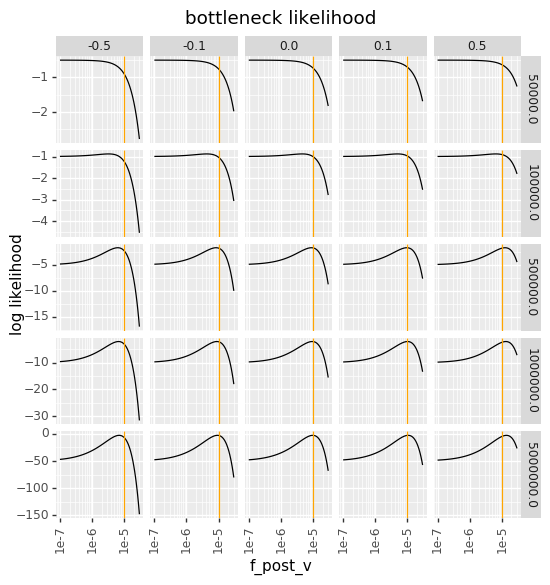

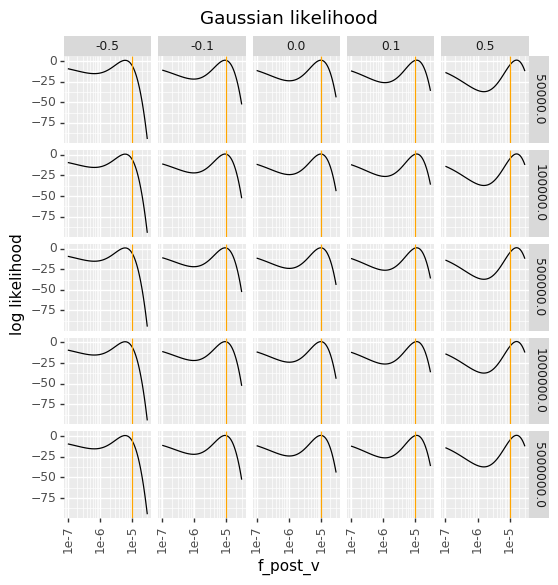

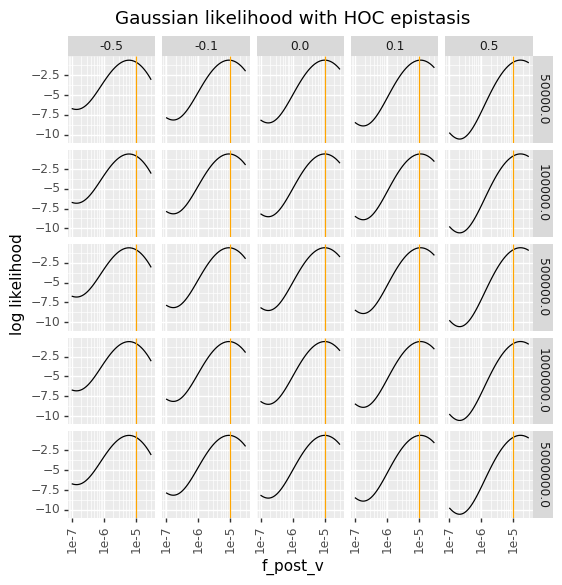

In [4]:
for loglik, title in [
        ('L_v', 'bottleneck likelihood'),
        ('G_v', 'Gaussian likelihood'),
        ('G_v_HOC', 'Gaussian likelihood with HOC epistasis')
        ]:
    p = (
     ggplot(df, aes('f_post_v', loglik)) +
     geom_path() + 
     facet_grid('N_bottle ~ p_v', scales='free_y') +
     scale_x_log10() +
     theme(figure_size=(6, 6),
           axis_text_x=element_text(angle=90)) +
     geom_vline(xintercept=f_pre_v, color='orange') +
     ylab('log likelihood') +
     ggtitle(title)
     )

    _ = p.draw()